In [2]:
%matplotlib inline

Goals of today's tutorial
==============

This tutorial will cover the basics of using Nilearn to do machine learning with neuroimages. It is meant for people who do not necessarily have a background in programming. 

Because the tutorial is at a Resting State and Brain Connectivity, we will focus primarily on using resting state connectivity data.

The specific goals of the day are broken into three sections:

### Section 1: Nilearn 101
* Use Python in a Jupyter notebook
* Learn about the Nilearn API
* Understand the difference between data stored in memory and data stored on disk
* Load, plot and save 3D images

### Section 2: Extracting features with Nilearn
* Load and plot 4D images
* Learn to extract rs-fmri data into connectivity features for machine learning

### Section 3: Machine learning with Nilearn
* Prepare a dataset for machine learning (i.e. train/test splits)
* Build and validate a machine learning model
* Use machine learning to predict unseen data
* Interpret the features of a machine learning model

### A few housekeeping notes:

Lots of fantastic tutorials exists on the Nilearn website. Learning to use Nilearn almost certainly starts here!
https://nilearn.github.io/index.html

If things go poorly on your computer, join us online using Google Colab:
*insert link here*

Don't be afraid to ask questions! We have TAs to help out. And stop me if I'm going to fast!

Don't forget, nobody ever writes error-free code!


Section 1: Nilearn 101
============

Here, we will learn how to run Python code in Jupyter notebooks, and learn a bit about how to use Nilearn

In [3]:
# Let's use this space to play a bit with Jupyter

### Basic nilearn example: manipulating and looking at data
A simple example showing how to load an existing Nifti file and use
basic nilearn functionalities.

In [1]:
# Let's use a Nifti file that is shipped with nilearn
from nilearn.datasets import MNI152_FILE_PATH

# Note that the variable MNI152_FILE_PATH is just a path to a Nifti file
print('Path to MNI152 template: %r' % MNI152_FILE_PATH)

//anaconda/envs/nilearn_tutorial/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Path to MNI152 template: '/Users/jakevogel/.local/lib/python3.6/site-packages/nilearn/datasets/data/avg152T1_brain.nii.gz'


### A first step: looking at our data
Let's quickly plot this file:

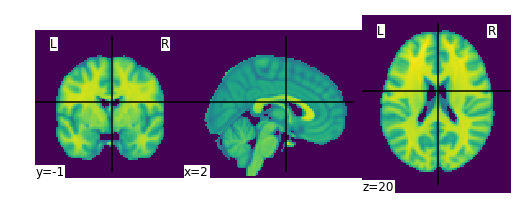

In [4]:
from nilearn import plotting
plotting.plot_img(MNI152_FILE_PATH)

**Exercise**: Try plotting one of your own files. In the above,
MNI152_FILE_PATH is nothing more than a string with a path pointing to
a nifti image. You can replace it with a string pointing to a file on
your disk. Note that it should be a 3D volume, and not a 4D volume.

In [ ]:
# Try to plot your own file here:

### Simple image manipulation: smoothing

Let's use an image-smoothing function from nilearn:
:func:`nilearn.image.smooth_img`

Functions containing 'img' can take either a filename or an image as input.

Here we give as inputs the image filename and the smoothing value in mm

In [5]:
from nilearn import image
smooth_anat_img = image.smooth_img(MNI152_FILE_PATH, fwhm=3)

# While we are giving a file name as input, the function returns
# an in-memory object:
print(smooth_anat_img)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (91, 109, 91)
affine: 
[[  -2.    0.    0.   90.]
 [   0.    2.    0. -126.]
 [   0.    0.    2.  -72.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3  91 109  91   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  2.  2.  2.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 8274.68
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'FSL3.3'
aux_file        : b''
qform_code      : mni
sform_cod

This is an in-memory object. We can pass it to nilearn function, for instance to look at it

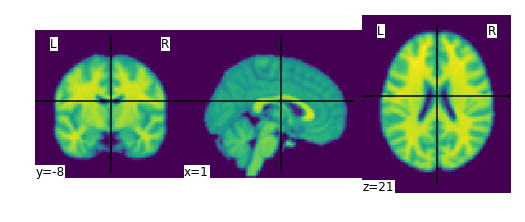

In [6]:
plotting.plot_img(smooth_anat_img)

We could also pass it to the smoothing function

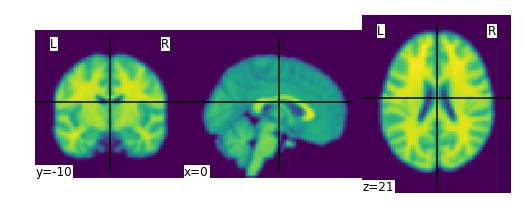

In [7]:
more_smooth_anat_img = image.smooth_img(smooth_anat_img, fwhm=3)
plotting.plot_img(more_smooth_anat_img)

Let's take a moment to think about the relative merits of in-memory vs. on disk

In [9]:
print(smooth_anat_img.shape)

(91, 109, 91)


In [10]:
x,y,z = smooth_anat_img.shape
print(x*y*z)

902629


Now imagine the size of a 4D image!

### Saving results to a file

We can save any in-memory object as follows:




In [ ]:
more_smooth_anat_img.to_filename('more_smooth_anat_img.nii.gz')


Section 2: Extracting signals from a brain parcellation
============================================

Here we show how to extract signals from a brain parcellation and compute
a correlation matrix.

We also show the importance of defining good confounds signals: the
first correlation matrix is computed after regressing out simple
confounds signals: movement regressors, white matter and CSF signals, ...
The second one is without any confounds: all regions are connected to
each other.


One reference that discusses the importance of confounds is `Varoquaux and
Craddock, Learning and comparing functional connectomes across subjects,
NeuroImage 2013
<http://www.sciencedirect.com/science/article/pii/S1053811913003340>`_.




Retrieve the atlas and the data
--------------------------------



Since we're using rs-fmri data, it makes sense to use an atlas defined using rs-fmri data

Let's use the MIST atlas, created here in Montreal using the BASC method. This atlas has multiple resolutions, for larger networks or finer-grained ROIs. Let's use a 64-ROI atlas to allow some detail, but to ultimately keep our connectivity matrices manageable

In [12]:
from nilearn import datasets

parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064


print('Atlas ROIs are located in nifti image (4D) at: %s' %
       atlas_filename)

Atlas ROIs are located in nifti image (4D) at: /Users/jakevogel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz


Let's have a look at that atlas

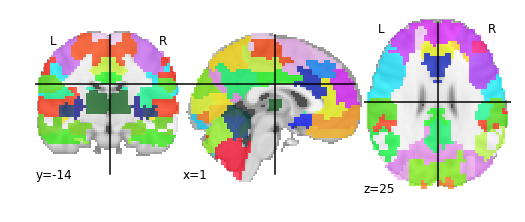

In [13]:
plotting.plot_roi(atlas_filename)

Great, let's load an example 4D fmri time-series for one subject

We have prepared some data especially for this tutorial. It is based on an open dataset of children and young adults. More details can be found here:

https://openneuro.org/datasets/ds000228/versions/00001

In [14]:
# You will have to change this directory so it points to the RS2018_Nilearn_tutorial git folder
git_path = '/Users/jakevogel/git/RS2018_Nilearn_tutorial/'

If you have already downloaded the data, this next line should happen instantly. Otherwise, the data download will begin.

In [16]:
import sys
sys.path.insert(0, git_path)
import download as dl

# One subject of resting-state data
data = dl.fetch_data(n_subjects=1)


/Users/jakevogel/git/RS2018_Nilearn_tutorial/download.py:68: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


Downloaded 91565296 of ? bytes. ...done. (28 seconds, 0 min)


Downloaded 7889 of ? bytes. ...done. (0 seconds, 0 min)


In [17]:
fmri_filenames = data.func[0]
print('fmri timeseries are located in nifti image (4D) at: %s' %
       fmri_filenames)  # 4D data

fmri timeseries are located in nifti image (4D) at: /Users/jakevogel/nilearn_data/ds000228/derivatives:fmriprep:sub-pixar001:sub-pixar001_task-pixar_run-001_swrf_bold.nii.gz


And let's have a look at that 4D resting-state image

In [18]:
plotting.plot_stat_map(fmri_filenames)

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See http://nilearn.github.io/manipulating_images/input_output.html.

Uh oh! An error! What's the problem here?

In [19]:
# Let's just a look at a single frame
# First we load the image into memory
myImg = image.load_img(fmri_filenames)
print(myImg.shape)

(79, 95, 68, 168)


In [20]:
# Now, let's isolate the first frame
first_frame = image.index_img(myImg, 0)
print(first_frame.shape)

(79, 95, 68)


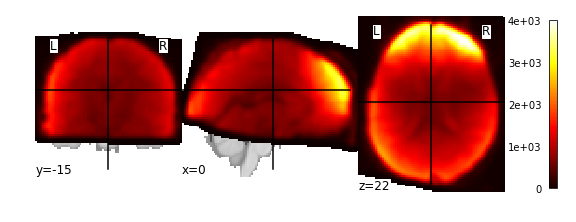

In [22]:
# Now let's try to plot it
plotting.plot_stat_map(first_frame)

The first frame can be a bit wonky. What about an average image?

In [27]:
averaged_Img = image.mean_img(image.mean_img(myImg))
averaged_data.shape

(79, 95, 68)

And plot!

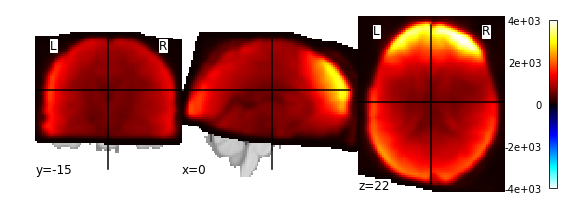

In [29]:
plotting.plot_stat_map(averaged_Img)

### Extract signals on a parcellation defined by labels
Using the NiftiLabelsMasker

So we've loaded our atlas and 4D data for a single subject. Let's practice extracting features!

In [33]:
# here is a short script to deal with the confounds in this particular dataset
# don't worry about the details
# but here is an example of how you can create your own function!

import h5py
import numpy as np

def prepare_confounds(conf, key = 'R', transpose=True):
    arrays = {}
    f = h5py.File(conf)
    for k, v in f.items():
        arrays[k] = np.array(v)
    
    if transpose:
        output = arrays[key].T
    else:
        output = arrays[key]
    
    return output

In [35]:
conf

array([[ 1.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        , ..., -0.3892175 ,
         0.41028064, -0.17032534],
       [ 0.        ,  0.        ,  1.        , ..., -0.778435  ,
         0.8205613 , -0.34065068],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -1.4232117 ,
        -0.74216944,  0.29651934],
       [ 0.        ,  0.        ,  0.        , ...,  0.18456283,
        -1.0422204 ,  0.44009268],
       [ 0.        ,  0.        ,  0.        , ...,  0.6521202 ,
        -2.3244655 ,  0.89524597]], dtype=float32)

In [36]:
from nilearn.input_data import NiftiLabelsMasker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=5)

# Here we go from nifti files to the signal time series in a numpy
# array. Note how we give confounds to be regressed out during signal
# extraction
conf = prepare_confounds(data.confounds[0])
time_series = masker.fit_transform(myImg, confounds=conf)

[NiftiLabelsMasker.fit_transform] loading data from /Users/jakevogel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
Resampling labels
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x1130c77b8>, <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x122b17f28>, 
{ 'background_label': 0,
  'detrend': False,
  'high_pass': None,
  'labels_img': '/Users/jakevogel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=array([[1.      , ..., 0.      ],
       ...,
       [0.      , ..., 0.895246

So what did we just create here?

In [37]:
type(time_series)

numpy.ndarray

In [38]:
time_series.shape

(168, 64)

Its a 168 (timeframes) x 64 (region) array!

What are these "confounds" and how are they used?

In [39]:
data.confounds

['/Users/jakevogel/nilearn_data/ds000228/derivatives:fmriprep:sub-pixar001:sub-pixar001_task-pixar_run-001_ART_and_CompCor_nuisance_regressors.mat']

In [41]:
conf.shape

(168, 29)

In [45]:
from pandas import DataFrame
DataFrame(conf).head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.270012,2.294844,-0.389217,0.410281,-0.170325
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.540024,4.589688,-0.778435,0.820561,-0.340651
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.810036,6.884532,-1.167652,1.230842,-0.510976
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.080048,9.179377,-1.556870,1.641123,-0.681301


### Compute and display a correlation matrix



In [46]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
correlation_matrix.shape

(64, 64)

Plot the correlation matrix

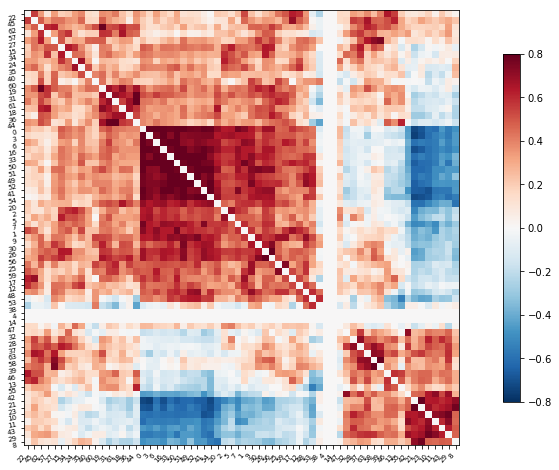

In [47]:
import numpy as np
# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

# The labels we have start with the background (0), hence we skip the
# first label
plotting.plot_matrix(correlation_matrix, figure=(10, 8), 
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=True)

# matrices are ordered for block-like representation

### Same thing without confounds, to stress the importance of confounds



[NiftiLabelsMasker.fit_transform] loading data from /Users/jakevogel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x1130c77b8>, <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x125b55518>, 
{ 'background_label': 0,
  'detrend': False,
  'high_pass': None,
  'labels_img': '/Users/jakevogel/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz',
  'low_pass': None,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, memory=Memory(cachedir='nilearn_cache/joblib'), memory_level=1, verbose=5)
[NiftiLabelsMa

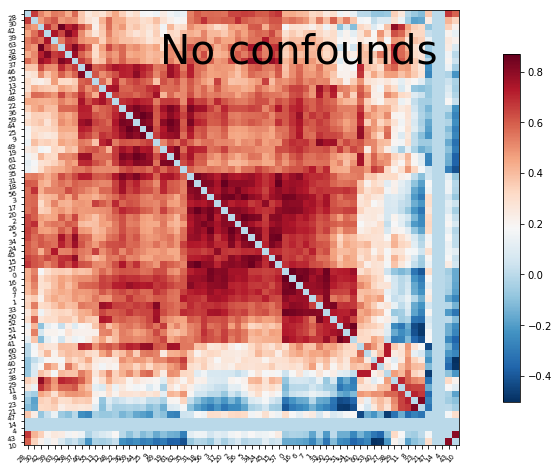

In [48]:
time_series = masker.fit_transform(myImg)
# Note how we did not specify confounds above. This is bad!

correlation_matrix = correlation_measure.fit_transform([time_series])[0]

# Mask the main diagonal for visualization:
np.fill_diagonal(correlation_matrix, 0)

plotting.plot_matrix(correlation_matrix, figure=(10, 8), 
                     labels=range(time_series.shape[-1]),
                    title='No confounds', reorder=True)

plotting.show()

# Section 3: Machine learning to predict age from rs-fmri

We will integrate what we've learned in the previous sections to extract data from rs-fmri images, and use that data as features in a machine learning model

The dataset consists of ~150 subjects, mostly young children and some young adults. We will use rs-fmri data to predict the age of the participants

### Load the data

If you already have downloaded the data, the next commands should load it. If you have not, the data will begin downloading. This is a lot of data (more than 1GB) so maybe not good to download right now!

You can still pop in after the "extract features" section

In [52]:
# if the data is already stored somewhere OR you want to store it somewhere, specify this here
wdir = '/Users/jakevogel/Science/Nilearn_tutorial/ds000028/'

# otherwise, comment the above and uncomment this
# wdir = None

In [54]:
# Now fetch the data
data = dl.fetch_data(None,data_dir=wdir)

/Users/jakevogel/git/RS2018_Nilearn_tutorial/download.py:68: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


How many individual subjects do we have?

In [56]:
len(data.func)

155

### Get Y and assess its distribution

In [59]:
# Let's load the phenotype data
pheno = DataFrame(data.phenotypic)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness,ToM_BookletMatched,ToM_BookletMatchedNOFB,FB_Composite,FB_Group,WPPSI_BD_raw,WPPSI_BD_scaled,KBIT_raw,KBIT_standard,DCCS_Summary,Scanlog_Scanner,Scanlog_Coil,Scanlog_Voxel_slize,Scanlog_Slice_Gap
0,b'sub-pixar001',4.774812,b'4yo',b'child',b'M',b'R',b'0.8',b'0.736842105',b'6',b'pass',b'22',b'13',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
1,b'sub-pixar002',4.856947,b'4yo',b'child',b'F',b'R',b'0.72',b'0.736842105',b'4',b'inc',b'18',b'9',b'n/a',b'n/a',b'2',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
2,b'sub-pixar003',4.153320,b'4yo',b'child',b'F',b'R',b'0.44',b'0.421052632',b'3',b'inc',b'15',b'9',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.1'
3,b'sub-pixar004',4.473648,b'4yo',b'child',b'F',b'R',b'0.64',b'0.736842105',b'2',b'fail',b'17',b'10',b'n/a',b'n/a',b'3',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.2'
4,b'sub-pixar005',4.837782,b'4yo',b'child',b'F',b'R',b'0.6',b'0.578947368',b'4',b'inc',b'13',b'5',b'n/a',b'n/a',b'2',b'3T1',b'7-8yo 32ch',b'3mm iso',b'0.2'


Looks like there is a column for age. Let's capture it in a variable

In [193]:
y_age = pheno['Age']
y_age.head()

0    4.774812
1    4.856947
2    4.153320
3    4.473648
4    4.837782
Name: Age, dtype: float64

Maybe we should have a look at the distribution of our target variable

The phenotype file comes with an AgeGroup variable. Let's take advantage of it to get a count on the age groups

In [64]:
pheno['AgeGroup'].value_counts()

b'8-12yo'    34
b'5yo'       34
b'Adult'     33
b'7yo'       23
b'3yo'       17
b'4yo'       14
Name: AgeGroup, dtype: int64

Seems pretty skewed toward younger children. Let's plot the actual age distribution

(array([67., 47.,  8.,  0., 11.,  8.,  6.,  4.,  3.,  1.]),
 array([ 3.51813826,  7.06632443, 10.61451061, 14.16269678, 17.71088296,
        21.25906913, 24.8072553 , 28.35544148, 31.90362765, 35.45181383,
        39.        ]),
 <a list of 10 Patch objects>)

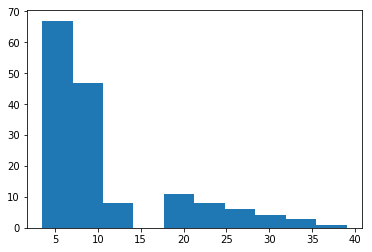

In [65]:
import matplotlib.pyplot as plt
plt.hist(y_age)

Very skewed indeed. Perhaps we will have better results by log-transforming age?

(array([26., 30., 17., 27., 20.,  2.,  2., 17.,  8.,  6.]),
 array([1.25793195, 1.49849492, 1.73905789, 1.97962086, 2.22018383,
        2.4607468 , 2.70130977, 2.94187274, 3.18243571, 3.42299868,
        3.66356165]),
 <a list of 10 Patch objects>)

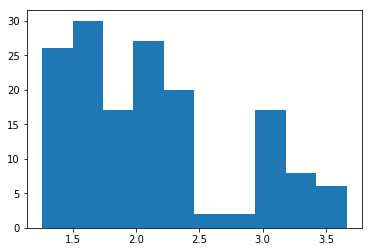

In [67]:
log_y_age = np.log(y_age)
plt.hist(log_y_age)


That's a bit better. Maybe we will want to use log-transformed age in our models?

### Extract features

Here, we are going to use the same techniques we learned in section 2 to extract rs-fmri connectivity features from every subject.

How are we going to do that? With a for loop.

Don't worry, it's not as scary as it sounds

In [69]:
# Here is a really simple for loop

for i in range(10):
    print('the number is', i)

the number is 0
the number is 1
the number is 2
the number is 3
the number is 4
the number is 5
the number is 6
the number is 7
the number is 8
the number is 9


In [71]:
container = []
for i in range(10):
    container.append(i)

container

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Now lets construct a more complicated loop to do what we want

First we do somethings we don't need to do in the loop. Let's re-iniate our masker and correlation_measure

In [75]:
# changing the verbosity of the masker
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, 
                           memory='nilearn_cache', verbose=0)
correlation_measure = ConnectivityMeasure(kind='correlation')

**NOTE**: On a laptop, this might take quite a long time. It took 30 minutes on my mac. 

**Maybe don't run it right now!**

In [ ]:
# from nilearn.connectome import sym_matrix_to_vec

# all_features = [] # here is where we will put the data (a container)

# for i,sub in enumerate(data.func):
#     # convert confounds to readable format
#     conf = prepare_confounds(data.confounds[i])
#     # extract the timeseries from the ROIs in the atlas
#     time_series = masker.fit_transform(sub, confounds=conf)
#     # create a region x region correlation matrix
#     correlation_matrix = correlation_measure.fit_transform([time_series])[0]
#     # isolate non-redundant features
#     upper_triang_corr = sym_matrix_to_vec(correlation_matrix, discard_diagonal=True)
#     # add to our container
#     all_features.append(upper_triang_corr)
#     # keep track of status
#     print('finished %s of %s'%(i+1,len(dataset.func)))

In [ ]:
# Let's save the data to disk
# import os
# outdir = os.getcwd()
# np.savez_compressed(os.path.join(outdir,'BASC064_features'),a = all_features, b = full_y)

And let's do another loop to get data without confounds regressed to see if it makes a difference

In [79]:
# from nilearn.connectome import sym_matrix_to_vec
# no_conf = [] 

# for i,sub in enumerate(data.func):
#     # notice we do not define or pass confounds here
#     time_series = masker.fit_transform(sub)
#     correlation_matrix = correlation_measure.fit_transform([time_series])[0]
#     upper_triang_corr = sym_matrix_to_vec(correlation_matrix, discard_diagonal=True)
#     no_conf.append(upper_triang_corr)
#     print('finished %s of %s'%(i+1,len(data.func)))

In [81]:
# Let's save the data to disk
# import os
# outdir = os.getcwd()
# np.savez_compressed(os.path.join(outdir,'BASC064_features_no_conf'),
#                    a = no_conf, b = y_age)

In case you do not want to run the full loop on your computer, you can load the output of the loop here!

In [192]:
feat_file = os.path.join(outdir,'BASC064_features.npz')
X_features = np.load(feat_file)['a']

In [90]:
X_features.shape

(155, 2016)

Okay so we've got our features. Why that shape?

In [93]:
# nfeat = 
# nfeat * (nfeat-1) / 2

We can visualize our feature matrix

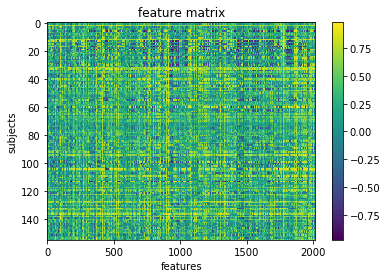

In [189]:
plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

### Prepare data for machine learning

Here, we will define a "training sample" where we can play around with our models. We will also set aside a "test" sample that we will not touch until the end

We want to be sure that our training and test sample are matched! We can do that with a "stratified split"

In [118]:
from sklearn.model_selection import train_test_split

# Split the sample to training/test with a 60/40 ratio, and 
# stratify by age group, and also shuffle the data.

X_train, X_test, y_train, y_test, ageGroup_train, ageGroup_test = train_test_split(
                                                                X_features, 
                                                                y_age, 
                                                                age_groups,
                                                                test_size = 0.4, 
                                                                shuffle = True,
                                                                stratify = age_groups,
                                                                random_state = 123
                                                                                   )

# print the size of our training and test groups
print('training:', len(X_train),
     'testing:', len(X_test))

training: 93 testing: 62


Let's visualize the distributions to be sure they are matched

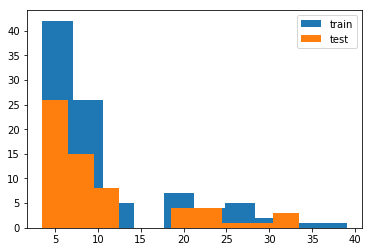

In [190]:
plt.hist(y_train, label = 'train')
plt.hist(y_test, label = 'test')
plt.legend()

### Run your first model!

Machine learning can get pretty fancy pretty quickly. We'll start with a very standard linear model called a Support Vector Regressor (SVR). 

While this may seem unambitious, simple models can be very robust. And we don't have enough data to create more complex models.

For more information, see this excellent resource:
https://hal.inria.fr/hal-01824205

Let's fit our first model!

In [196]:
from sklearn.svm import SVR

l_svr = SVR(kernel='linear') # define the model

l_svr.fit(X_train, y_train) # fit the model

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Well... that was easy. Let's see how well the model learned the data!

We will judge our model on two criteria:
* R2 = r-sqaure: the variance of the test data explained by the model
* mae = mean absolute error: how off our measurements are in absolute units (years!)

In [197]:
from sklearn.metrics import mean_absolute_error

y_pred = l_svr.predict(X_train) # predict the training data based on the model
r2 = l_svr.score(X_train, y_train) # get the r2
mae = mean_absolute_error(y_true = y_train, 
                          y_pred = y_pred) # get the mae

Let's view our results and plot them all at once!

r2 = 0.9998459312006879, mae = 0.09982955004718268


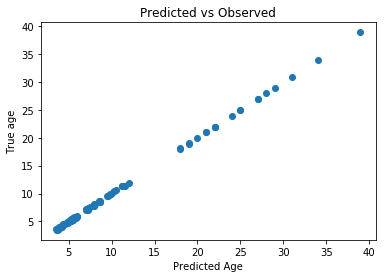

In [198]:
print('r2 = %s, mae = %s'%(r2,mae))

plt.scatter(y_train, y_pred)
plt.title('Predicted vs Observed')
plt.xlabel('Predicted Age')
plt.ylabel('True age')

HOLY COW! Machine learning is amazing!!! Almost a perfect fit!

...which means there's something wrong. What's the problem here?

In [125]:
from sklearn.model_selection import cross_val_predict, cross_val_score

# predict
y_pred = cross_val_predict(l_svr, X_train, y_train, 
                           groups=ageGroup_train, cv=10)
# scores
r2 = cross_val_score(l_svr, X_train, y_train, 
                     groups=ageGroup_train, cv=10)
mae_score = cross_val_score(l_svr, X_train, y_train, 
                            groups=ageGroup_train, cv=10,
                           scoring = 'neg_mean_absolute_error')

We can look at the accuracy of the predictions for each fold of the cross-validation

In [131]:
print(r2)

[-2.80638341  0.7303517   0.78370326  0.64741573  0.50406747  0.73287536
  0.66216006  0.47937879 -5.74156208  0.60543526]


We can also look at the overall accuracy of the model

r2 = 0.6162064224361791, mae = 3.8564063319286546


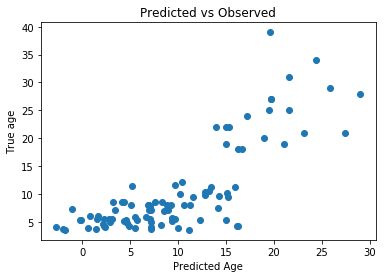

In [135]:
from sklearn.metrics import r2_score

overall_r2 = r2_score(y_pred = y_pred, y_true = y_train)
overall_mae = mean_absolute_error(y_pred = y_pred, y_true = y_train)
print('r2 = %s, mae = %s'%(overall_r2,overall_mae))

plt.scatter(y_pred, y_train)
plt.title('Predicted vs Observed')
plt.xlabel('Predicted Age')
plt.ylabel('True age')

Not too bad at all! But what are some things you notice about our results?

### Tweak your model

It's very important to learn when and where its appropriate to "tweak" your model.

Since we have done all of the previous analysis in our training data, it's find to try different models. But we **absolutely cannot** "test" it on our left out data. If we do, we are in great danger of overfitting.

We could try other models, or tweak hyperparameters, but we are probably not power sufficiently to do so, and would once again risk overfitting.


But we can perhaps look at the performance of the model on log-transformed data

In [139]:
log_y_train = np.log(y_train) # log-transform target data

r2 = 0.6067900892749318, mae = 0.3171767357183989


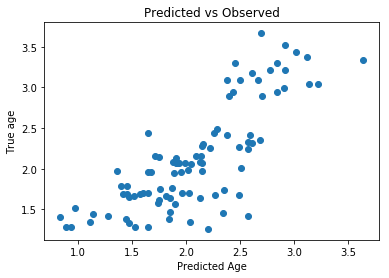

In [142]:
# repeat the steps above to re-fit the model 
# and assess its performance

# don't forget to switch y_train to log_y_train
y_pred = cross_val_predict(l_svr, X_train, log_y_train, groups=ageGroup_train, cv=10)
r2 = cross_val_score(l_svr, X_train, log_y_train, groups=ageGroup_train, cv=10)
mae_score = cross_val_score(l_svr, X_train, log_y_train, groups=ageGroup_train, cv=10,
                           scoring = 'neg_mean_absolute_error')

# don't forget to switch y_train to log_y_train
overall_r2 = r2_score(y_pred = y_pred, y_true = log_y_train)
overall_mae = mean_absolute_error(y_pred = y_pred, y_true = log_y_train)
print('r2 = %s, mae = %s'%(overall_r2,overall_mae))

plt.scatter(y_pred, log_y_train)
plt.title('Predicted vs Observed')
plt.xlabel('Predicted Age')
plt.ylabel('True age')

What do you think about the results of this model compared to the non-transformed model?

**Exercise:** Try fitting a new SVR model and tweak one of the many parameters. Run cross-validation and see how well it goes. Make a new cell and type SVR? to see the possible hyperparameters

In [ ]:
# new_model = SVR() 

### Can our model predict age in completely un-seen data?
Now that we're fit a model we think has possibly learned how to decode age based on rs-fmri signal, let's put it to the test. We will train our model on all of the training data, and try to predict the age of the subjects we left out at the beginning of this section.

Because we performed a transformation on our training data, we will need to transform our testing data using the *same information!* 

For that, we will need to create a transformer

In [143]:
# transform testing set based on training distribution...
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log).fit(y_train.values.reshape(-1,1))
log_y_test = transformer.transform(y_test.values.reshape(-1,1))[:,0]

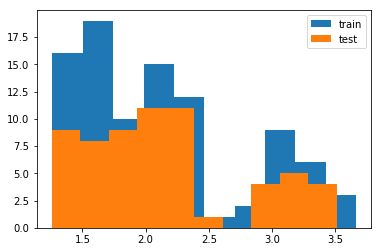

In [147]:
# how did we do?
plt.hist(log_y_train, label = 'train')
plt.hist(log_y_test, label = 'test')
plt.legend()

And now for the moment of truth! 

No cross-validation needed here. We simply fit the model with the training data and use it to predict the testing data

I'm so nervous. Let's just do it all in one cell

r2 = 0.5645052266954728, mae = 0.35719953873825666


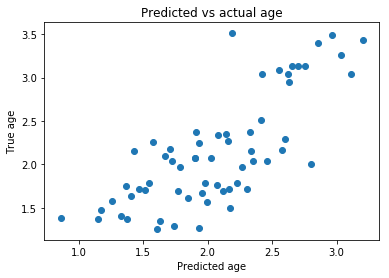

In [149]:
l_svr.fit(X_train, log_y_train) # fit to training data
y_pred = l_svr.predict(X_test) # predict age using testing data
r2 = l_svr.score(X_test, log_y_test) # get r2 score
mae = mean_absolute_error(y_pred=y_pred, y_true=log_y_test) # get mae

# print results
print('r2 = %s, mae = %s'%(r2,mae))

# plot results
plt.scatter(y_pred, log_y_test)
plt.title('Predicted vs actual age')
plt.xlabel('Predicted age')
plt.ylabel('True age')

***Wow!!*** Congratulations. You just trained a machine learning model that used real rs-fmri data to predict the age of real humans.

It seems like something in this data does seem to be systematically related to age ... but what?  

### Interpreting model feature importances
Interpreting the feature importances of a machine learning model is a real can of worms. This is an area of active research. Unfortunately, it's hard to trust the feature importance of some models. 

You can find a whole tutorial on this subject here:
http://gael-varoquaux.info/interpreting_ml_tuto/index.html

For now, we'll just eschew better judgement and take a look at our feature importances

We can access the feature importances (weights) used my the model

In [166]:
l_svr.coef_

array([[-0.00784157, -0.0063221 ,  0.00710295, ...,  0.01095685,
        -0.01118909,  0.00592823]])

lets plot these weights to see their distribution better

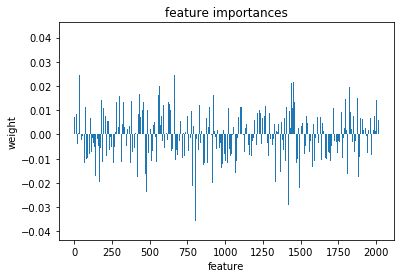

In [167]:
plt.bar(range(l_svr.coef_.shape[-1]),l_svr.coef_[0])
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')

Or perhaps it will be easier to visualize this information as a matrix similar to the one we started with

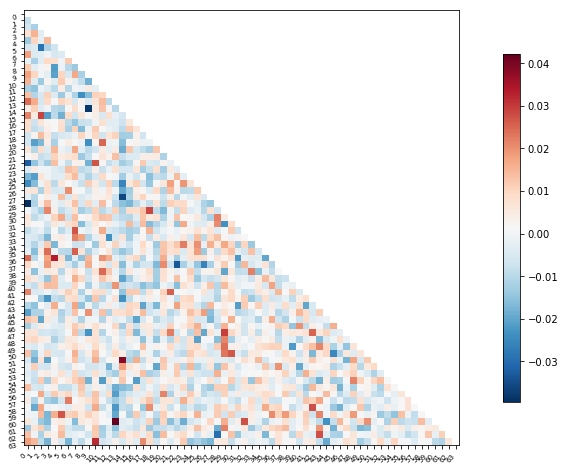

In [176]:
# A little matrix manipulation to wrangle our features 

n_roi = 64
feat_exp_matrix = np.zeros((n_roi,n_roi))
upper_tri_coord = np.triu_indices_from(feat_exp_matrix,1)
feat_exp_matrix[upper_tri_coord] = l_svr.coef_[-1]
feat_exp_matrix.T[upper_tri_coord] = feat_exp_matrix[upper_tri_coord]

# and plot a heatmap
plotting.plot_matrix(feat_exp_matrix, figure=(10, 8), 
                     labels=range(n_roi),
                     reorder=False,
                    tri='lower')

Let's see if we can throw those features onto an actual brain.

First, we'll need to gather the coordinates of each ROI of our atlas

In [182]:
# from nibabel import Nifti1Image

# def lazy_get_coords(atlas_filename):
#     coords = []
#     img = image.load_img(atlas_filename)
#     atlas_data = img.get_data()
#     aff = img.affine
#     values = np.unique(atlas_data)[1:]
#     for i in values:
#         roi = np.zeros_like(atlas_data)
#         roi[atlas_data==i] = 1.0
#         coords.append(plotting.find_xyz_cut_coords(Nifti1Image(roi,aff)))
    
#     return coords

In [183]:
# atlas_coordinates = lazy_get_coords(atlas_filename)
# np.savez_compressed(os.path.join(outdir,'BASC064_coordinates'),
#                    a = atlas_coordinates)

In [187]:
coords = np.load(os.path.join(outdir,'BASC064_coordinates.npz'))['a']

And now we can use our feature matrix and the wonders of nilearn to create a connectome map where each node is an ROI, and each connection is weighted by the importance of the feature to the model

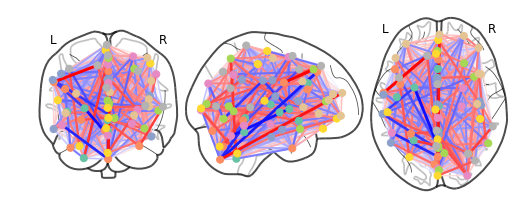

In [188]:
plotting.plot_connectome(feat_exp_matrix, coords)

# Appendix: Goodies and extra points

**Exercise:** There are is a clear distinction between adults in children in this dataset. See if you can train a classifier (for example, SVC) to predict which subjects are adults and which are children. 

Return your overall accuracy, but also the positive predictive value (precisions score). You can tweak your model, but remember, don't burn your test data or your results don't count! Also remember you don't have many subjects to work with in the first place. 

For a bonus, plot the feature importances, and correlate the feature importances with those from our linear model predicting age

In [ ]:
# from sklearn.svm import SVC
# y_class_train = [1 if x==b'Adult' else 0 for x in ageGroup_train]
# y_class_test = [1 if x==b'Adult' else 0 for x in ageGroup_test]